# 1. Introdução e Metadados

Este notebook realiza a análise exploratória (camada Bronze) do dataset Olist (ecommerce brasileiro). O objetivo é reproduzir o estilo e rigor do notebook de referência (Airbnb) aplicado ao contexto dos CSVs do repositório.

### 1.1 Fontes e Contexto
- **Data Source:** Kaggle - Brazilian E-Commerce Public Dataset by Olist
- **URL:** https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
- **Fonte dos dados:** Conjunto de CSVs fornecidos pelo repositório Olist (pasta `DataLayer/raw`).
- **Escopo:** Exploraremos pedidos, itens, pagamentos, avaliações, clientes, produtos, vendedores e geolocalização para entender qualidade, duplicatas, formatos e distribuições principais.

### 1.2 Estrutura esperada
- `orders`: pedidos e timestamps
- `items`: itens por pedido (product_id, price, freight)
- `payments`: formas e valores de pagamento
- `reviews`: avaliações e notas
- `customers`, `products`, `sellers`, `geolocation`

### 1.3 Observações sobre qualidade
- Este notebook prioriza diagnósticos de qualidade (valores ausentes, duplicados, tipos incorretos) e visualizações analogas ao notebook de referência (anotações e percentuais nas figuras).
- As células a seguir carregam os CSVs e executam checks replicando o estilo do exemplo do Airbnb, mas aplicado aos seus dados.
- Esses são dados comerciais reais, foram anonimizados e as referências às empresas e parceiros no texto da análise foram substituídas pelos nomes das grandes casas de Game of Thrones.

**Atenção**

- Um pedido pode ter vários itens.

- Cada item pode ser atendido por um vendedor diferente.

- Todos os textos que identificam lojas e parceiros foram substituídos pelos nomes das grandes casas de Game of Thrones.

**Esquema de dados:**

![alt text](../assets/image.png)


## 2. Análise Exploratória
A seguir, utilizaremos Python para auxiliar na análise dos dados brutos. Com a biblioteca Pandas, podemos visualizar e alterar os dados utilizando Dataframes e Series. Uma Series é um array unidimensional, e um Dataframe é como uma tabela, em que cada coluna é uma Series.

Além dessas bibliotecas, também podemos usar a seaborn para desenhar gráficos com base nos dados das Series e Dataframes.

### 2.1 Importação das bibliotecas e carregamento do Dataset


In [15]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import missingno as msno
from pathlib import Path


### 2.2 Carregamento Automático de Dataset

O código abaixo automatiza a importação de todos os arquivos de dados brutos (.csv) presentes no diretório atual (./raw).

Ele utiliza:

- `glob.glob('./*.csv')`: Para encontrar todos os arquivos CSV.

- `os.path.basename` e .`replace`: Para criar um nome de tabela limpo (sem o .csv).

- Dicionário `dataframes`: Todos os DataFrames são carregados e armazenados neste dicionário, onde a chave é o nome da tabela e o valor é o DataFrame do Panda

In [22]:
dataframes = {}
file_pattern = './*.csv' 
csv_files = glob.glob(file_pattern)
print(f"Arquivos CSV encontrados: {len(csv_files)}")

for file_path in csv_files:
    # Obtém o nome limpo para usar como chave do dicionário
    file_name = os.path.basename(file_path) 
    table_name = file_name.replace('.csv', '')

    try:
    # Carrega o CSV. low_memory=False para garantir tipos de coluna corretos.
        print(f"Carregando: {file_name}")
        df = pd.read_csv(file_path, sep=",", encoding='utf8', low_memory=False)

        # Armazena no df no dicionário
        dataframes[table_name] = df
        print(f"   -> {table_name} carregado com {df.shape[0]} linhas.")

    except Exception as e:
        print(f"ERRO ao carregar {file_name}: {e}")
        
print("-" * 30)
print("Carregamento concluído.")
print(f"DataFrames carregados ({len(dataframes)}): {list(dataframes.keys())}")


Arquivos CSV encontrados: 9
Carregando: olist_customers_dataset.csv
   -> olist_customers_dataset carregado com 99441 linhas.
Carregando: olist_geolocation_dataset.csv
   -> olist_geolocation_dataset carregado com 1000163 linhas.
Carregando: olist_orders_dataset.csv
   -> olist_orders_dataset carregado com 99441 linhas.
Carregando: olist_order_items_dataset.csv
   -> olist_order_items_dataset carregado com 112650 linhas.
Carregando: olist_order_payments_dataset.csv
   -> olist_order_payments_dataset carregado com 103886 linhas.
Carregando: olist_order_reviews_dataset.csv
   -> olist_order_reviews_dataset carregado com 99224 linhas.
Carregando: olist_products_dataset.csv
   -> olist_products_dataset carregado com 32951 linhas.
Carregando: olist_sellers_dataset.csv
   -> olist_sellers_dataset carregado com 3095 linhas.
Carregando: product_category_name_translation.csv
   -> product_category_name_translation carregado com 71 linhas.
------------------------------
Carregamento concluído.
D

In [ ]:
# Acessar o DataFrame de clientes
df_customers = dataframes['olist_customers_dataset']
df_customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [25]:
# Acessar o DataFrame de pedidos
df_orders = dataframes['olist_orders_dataset']
df_orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


### 2.3 Dimensões do Dataset

In [45]:
## Verificação das Dimensões de Todos os Datasets

print("--- DIMENSÕES DE TODOS OS DATASETS CARREGADOS ---")
print("-" * 50)

# Itera sobre o dicionário 'dataframes'. 
# 'nome_tabela' será a chave (ex: 'olist_customers_dataset') e 'df' o valor (o DataFrame)
for nome_tabela, df in dataframes.items():
    
    # Obtém o número de linhas e colunas usando a desestruturação (unpacking)
    linhas, colunas = df.shape
    
    # Imprime os resultados de forma formatada
    print(f" {nome_tabela.ljust(20)}\n ")
    print(f" {'Linhas (Tuplas):'.ljust(20)} -> {str(linhas).rjust(5)} ")
    print(f" {'Colunas:'.ljust(20)} -> {str(colunas).rjust(5)} ")
    print("-" * 50)

--- DIMENSÕES DE TODOS OS DATASETS CARREGADOS ---
--------------------------------------------------
 olist_customers_dataset
 
 Linhas (Tuplas):     -> 99441 
 Colunas:             ->     5 
--------------------------------------------------
 olist_geolocation_dataset
 
 Linhas (Tuplas):     -> 1000163 
 Colunas:             ->     5 
--------------------------------------------------
 olist_orders_dataset
 
 Linhas (Tuplas):     -> 99441 
 Colunas:             ->     8 
--------------------------------------------------
 olist_order_items_dataset
 
 Linhas (Tuplas):     -> 112650 
 Colunas:             ->     7 
--------------------------------------------------
 olist_order_payments_dataset
 
 Linhas (Tuplas):     -> 103886 
 Colunas:             ->     5 
--------------------------------------------------
 olist_order_reviews_dataset
 
 Linhas (Tuplas):     -> 99224 
 Colunas:             ->     7 
--------------------------------------------------
 olist_products_dataset
 
 Linhas

## 2.4 Identificação das Colunas e Tipos de Dados

Depois de reconhecer as dimenções gerais de cada csv vamos fazer uma analise mais aprofundada das colunas e dos tipos de dados que temos.

In [67]:
for nome_tabela, df in dataframes.items():

    print("\n\n")
    print("-" * 70)
    print(f"TABELA: {nome_tabela.upper()}")
    print("-" * 70)

    #colunas
    print(df.columns)
    





----------------------------------------------------------------------
TABELA: OLIST_CUSTOMERS_DATASET
----------------------------------------------------------------------
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')



----------------------------------------------------------------------
TABELA: OLIST_GEOLOCATION_DATASET
----------------------------------------------------------------------
Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')



----------------------------------------------------------------------
TABELA: OLIST_ORDERS_DATASET
----------------------------------------------------------------------
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_e

#### Agora que ja vismos as colunas vamos verificar os tipos de dados(dtypes) que temos

In [68]:
for nome_tabela, df in dataframes.items():
      
    print("\n\n")
    print("-" * 70)
    print(f"TABELA: {nome_tabela.upper()}")
    print("-" * 70)

  # tipos de dados
    print(df.dtypes)




----------------------------------------------------------------------
TABELA: OLIST_CUSTOMERS_DATASET
----------------------------------------------------------------------
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix    object
customer_city               object
customer_state              object
dtype: object



----------------------------------------------------------------------
TABELA: OLIST_GEOLOCATION_DATASET
----------------------------------------------------------------------
geolocation_zip_code_prefix     object
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object



----------------------------------------------------------------------
TABELA: OLIST_ORDERS_DATASET
----------------------------------------------------------------------
order_id                         object
customer_id                     

A análise dos dtypes e das colunas revela que, embora muitos tipos estejam corretos (IDs como object, valores como float), há um problema sistêmico com a interpretação de colunas de tempo e de localização. O problema principal é:

- Datas Incorretas (Tipo Object): Todas as colunas que representam datas e tempo, presentes nas tabelas `OLIST_ORDERS_DATASET`, `OLIST_ORDER_ITEMS_DATASET` e `OLIST_ORDER_REVIEWS_DATASET`, foram classificadas incorretamente como object (texto/string). 


## 2.5 Qualidade dos Dados


### 2.5.1 Análise de Valores Ausentes (Nulos/NaN)


### Análise da Qualidade dos Dados dos Datasets Olist

Ao inspecionar todos os DataFrames do projeto Olist percebemos a presença de valores nulos significativos em três tabelas.

#### Integridade dos Dados (Valores Ausentes)

A maioria dos datasets, incluindo `Clientes`, `Geolocalização`, `Itens do Pedido`, `Pagamentos`, `Vendedores` e `Tradução de Categorias`, está completamente preenchida, sem a presença de valores nulos (NaNs). Os problemas de dados ausentes estão concentrados em:

- Avaliações (`OLIST_ORDER_REVIEWS_DATASET`): Esta tabela tem a maior lacuna. A coluna de título do comentário (review_comment_title) está vazia em 88.34% dos registros, e a mensagem do comentário (review_comment_message) está vazia em 58.70%. Isso é esperado, pois o preenchimento desses campos é opcional para o cliente, mas exige que os nulos sejam tratados como strings vazias para análise de texto.

- Pedidos (`OLIST_ORDERS_DATASET`): Cerca de 3.00% dos registros (2.980 linhas) possuem alguma data de entrega ausente (order_delivered_customer_date). Essa ausência de data é, na verdade, uma *informação importante* que indica pedidos cancelados, perdidos ou ainda em trânsito. Importante ser analisado

- Produtos (`OLIST_PRODUCTS_DATASET`): Uma pequena parte dos registros, 1.85% (610 linhas), tem o nome da categoria (product_category_name) e as informações de dimensões do produto (*lenght, *description_lenght, product_photos_qty) faltando simultaneamente. Os demais 32.341 produtos estão completos.

In [84]:
for nome_tabela, df in dataframes.items():
    
    print("\n" + "="*80)
    print(f"DIAGNÓSTICO DE COLUNAS PARA: {nome_tabela.upper()}")
    print("="*80)
    
    na_count = df.isnull().sum()
    not_null_count = df.count()
    
    summary_df = pd.DataFrame({ 'Dtype': df.dtypes,'Não Nulos': not_null_count, 'Nulos': na_count, 'Total Linhas': len(df)})
    
    print(summary_df)
    print("\n[Contagem Nulos por Coluna]: ")
    
    nulos_sum = df.isnull().sum().sort_values(ascending=False)
    nulos_sum = nulos_sum[nulos_sum > 0]
    
    if not nulos_sum.empty:
        # Calcula a porcentagem para ser mais informativo
        nulos_perc = (nulos_sum / len(df) * 100).map('{:.2f}%'.format)
        nulos_info_df = pd.DataFrame({
            'Contagem': nulos_sum,
            'Porcentagem': nulos_perc
        })
        print(nulos_info_df)
    else:
        print("-> Nenhum valor nulo encontrado nesta tabela.")

    print("\n")



DIAGNÓSTICO DE COLUNAS PARA: OLIST_CUSTOMERS_DATASET
                           Dtype  Não Nulos  Nulos  Total Linhas
customer_id               object      99441      0         99441
customer_unique_id        object      99441      0         99441
customer_zip_code_prefix  object      99441      0         99441
customer_city             object      99441      0         99441
customer_state            object      99441      0         99441

[Contagem Nulos por Coluna]: 
-> Nenhum valor nulo encontrado nesta tabela.



DIAGNÓSTICO DE COLUNAS PARA: OLIST_GEOLOCATION_DATASET
                               Dtype  Não Nulos  Nulos  Total Linhas
geolocation_zip_code_prefix   object    1000163      0       1000163
geolocation_lat              float64    1000163      0       1000163
geolocation_lng              float64    1000163      0       1000163
geolocation_city              object    1000163      0       1000163
geolocation_state             object    1000163      0       1000163

[Conta


### 2.5.2 Visualização Unificada de Dados Ausentes

Para obter um panorama completo da qualidade de dados do projeto, o gráfico de barras abaixo combina os percentuais de nulos de **todas as colunas** que contêm dados faltantes em todos os DataFrames.

Esta visualização consolidada facilita a identificação das prioridades de limpeza:

  * **Prioridade Máxima (Vermelho \>50%):** As colunas de comentários de revisão (`review_comment_title` e `review_comment_message`) são opcionais e estão quase inteiramente vazias, exigindo que os nulos sejam tratados como *strings* vazias.
  * **Prioridade Alta (Laranja 10-50%):** Nenhuma coluna nesta faixa.
  * **Prioridade Média (Azul \<10%):** As datas de entrega e envio dos pedidos (`order_delivered_customer_date`, `order_delivered_carrier_date`) e as informações de categoria/dimensão de alguns produtos representam as lacunas estruturais do negócio (como pedidos que não foram concluídos ou produtos sem especificações).


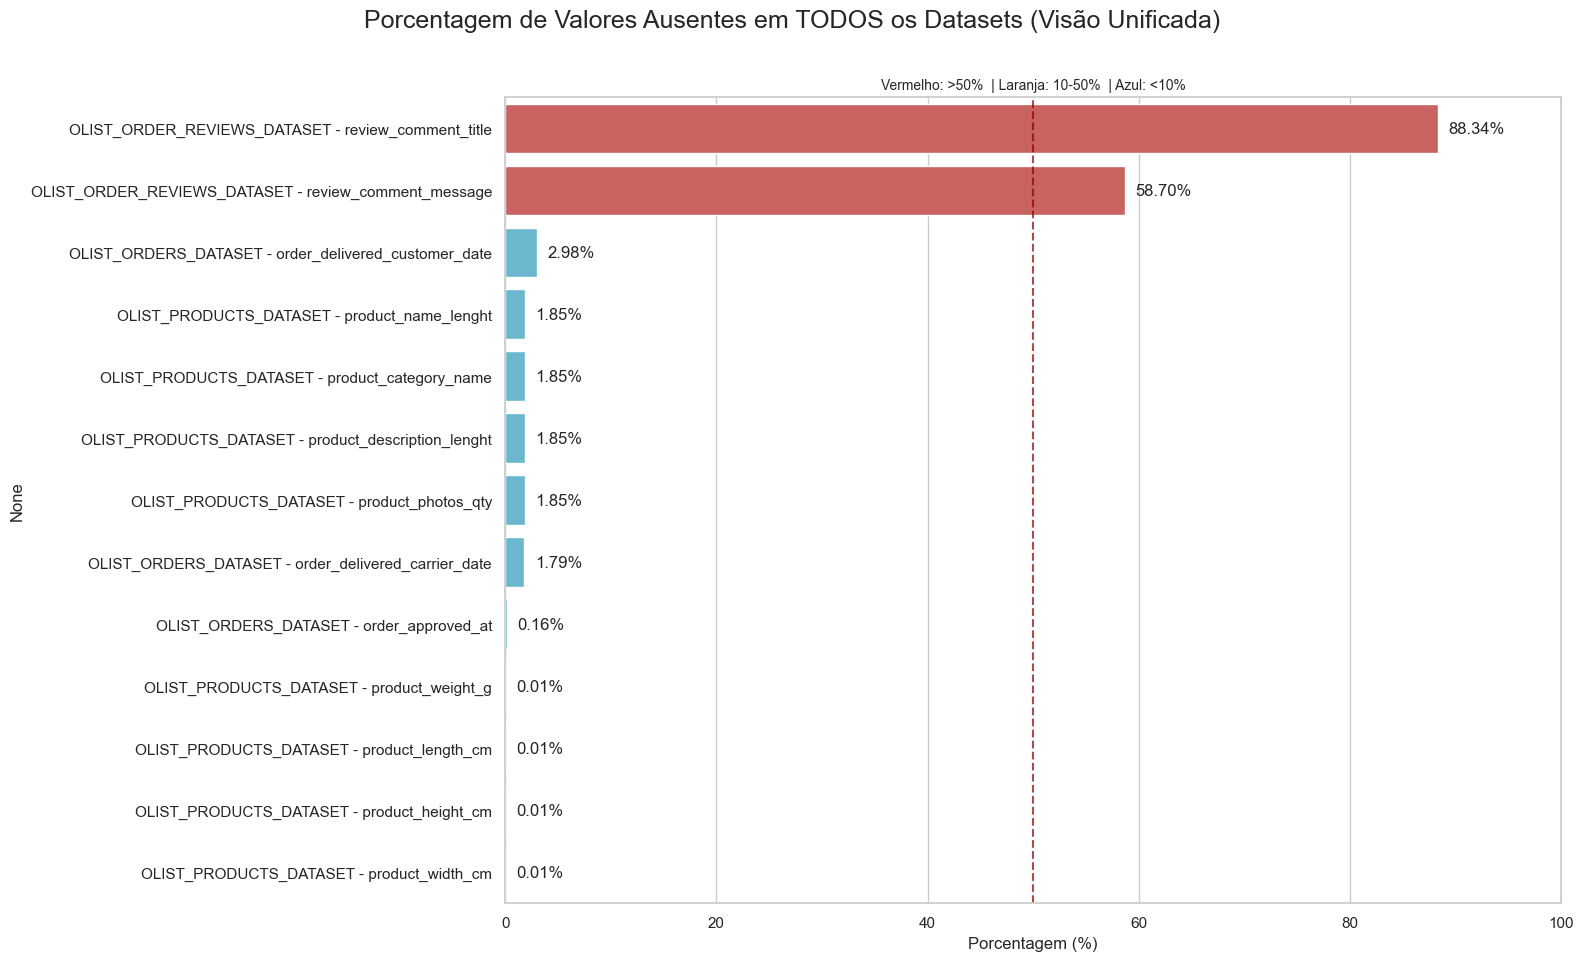

In [ ]:
resumo_nulos_global = {}

# Calcula o percentual de nulos de todas as colunas em todos os DataFrames
for nome_tabela, df in dataframes.items():
    null_perc_df = (df.isnull().sum() / len(df) * 100)
    null_perc_df = null_perc_df[null_perc_df > 0] # Filtra colunas com nulos

    # Adiciona prefixo da tabela ao nome da coluna
    for col, perc in null_perc_df.items():
        resumo_nulos_global[f"{nome_tabela.upper()} - {col}"] = perc

null_perc_global = pd.Series(resumo_nulos_global).sort_values(ascending=False)

if not null_perc_global.empty:
    colors = [
        '#d9534f' if v > 50 else '#f0ad4e' if v > 10 else '#5bc0de' 
        for v in null_perc_global.values
    ]
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(16, max(10, len(null_perc_global) * 0.7))) 
    
    ax = sns.barplot(
        x=null_perc_global.values, 
        y=null_perc_global.index, 
        hue=null_perc_global.index, 
        palette=colors, 
        legend=False
    )
    
    plt.suptitle("Porcentagem de Valores Ausentes em TODOS os Datasets (Visão Unificada)", fontsize=18, y=0.96)
    ax.set_title("Vermelho: >50%  | Laranja: 10-50%  | Azul: <10%", fontsize=10)
    ax.set_xlabel("Porcentagem (%)")
    ax.set_xlim(0, 100)
    
    # Adiciona rótulos de porcentagem
    for p in ax.patches:
        w = p.get_width()
        ax.text(w + 1, p.get_y() + p.get_height()/2, f'{w:.2f}%', va='center')
        
    ax.axvline(50, color='darkred', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("Nenhum valor nulo encontrado nos datasets para plotagem.")

In [ ]:
# 2.1 Importação das bibliotecas e carregamento dos CSVs (adaptado ao projeto Olist)
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import missingno as msno

# Diretório onde estão os CSVs do raw
RAW_DIR = Path('DataLayer/raw')

# Carrega todos os CSVs da pasta raw em um dicionário `datasets` com chave = nome do arquivo sem extensão
datasets = {}
for fp in RAW_DIR.glob('*.csv'):
    name = fp.stem
    try:
        df = pd.read_csv(fp, sep=',', encoding='utf8', low_memory=False)
        datasets[name] = df
        print(f'Carregado: {name} — {df.shape[0]:,} linhas × {df.shape[1]} colunas')
    except Exception as e:
        print(f'Falha ao carregar {fp}: {e}')

# Define MAIN_DF: prefer 'orders' se existir, senão o primeiro dataframe carregado
if 'orders' in datasets:
    MAIN_DF = datasets['orders']
elif datasets:
    MAIN_DF = next(iter(datasets.values()))
else:
    MAIN_DF = None

print('\nResumo dos datasets carregados:')
for k, v in datasets.items():
    print(f' - {k}: {v.shape[0]:,} × {v.shape[1]}')

# Exemplo rápido: mostrar as colunas e dtypes do MAIN_DF (se existir)
if MAIN_DF is not None:
    display(MAIN_DF.dtypes.reset_index().rename(columns={'index':'coluna', 0:'dtype'}))
else:
    print('MAIN_DF não definido — nenhum CSV foi carregado da pasta DataLayer/raw.')

In [ ]:
# imports principais (guardados quando necessário)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import numpy as np
from IPython.display import display
import pycountry
import plotly.express as px
import geopandas as gpd
import matplotlib.colors as mcolors
from branca.element import Template, MacroElement
import missingno as msno
from pathlib import Path

# folium e plugins: importar com proteção (não faz o notebook quebrar se o pacote não estiver instalado)
try:
    import folium
    from folium.plugins import FastMarkerCluster, HeatMap
    FOLIUM_AVAILABLE = True
except Exception as e:
    FOLIUM_AVAILABLE = False
    print("Aviso: pacote 'folium' não está instalado ou falhou ao importar. Para usar mapas, instale 'folium' e 'branca'.\n", e)


In [ ]:
# 2.2 Head do Dataset — mostra as 5 primeiras linhas do MAIN_DF e de cada dataset carregado (se desejar)
from IPython.display import display

if 'MAIN_DF' in globals() and MAIN_DF is not None:
    print('### MAIN_DF — 5 primeiras linhas')
    display(MAIN_DF.head(5))
else:
    print('MAIN_DF não definido — rode a célula 2.1 para carregar os dados.')

# Opcional: mostrar head de cada dataframe carregado em `datasets` (com um título claro)
for name, df in (datasets.items() if 'datasets' in globals() else []):
    print(f'--- {name} — shape: {df.shape[0]:,} × {df.shape[1]}')
    display(df.head(5))
